# Building New Data Driven PRF Models for `pandora-psf` NIR

To build a PRF model for the NIR we're going to keep everything in **pixel** dimensions not wavelength dimensions. We'll assume for the PRF we can use a Gaussian with some width. 

We need to find

- Pixel x position of the trace
- Pixel y position of the trace
- The width of the Gaussian along the trace.

In this example we're going to assume that the trace is completely vertical. 

To do this we'll generate some fake data

In [1]:
import lamatrix
import pandorapsf as pp
import pandorasat as ps
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
nirda = ps.NIRDetector()
p = pp.PSF.from_name("nirda_fallback", transpose=True)
wav, sed = ps.phoenix.get_phoenix_model(9000, jmag=7)
ts = pp.TraceScene(np.asarray([[300, 40]]), psf=p, wavelength=p.trace_wavelength[:-1])
flux = (ts.integrate_spectrum(wav, sed))

In [3]:
data = (ts.model(flux)[0] * nirda.frame_time()).to(u.electron/u.pixel).value

In [4]:
data[data > 0] = np.random.poisson(data[data > 0])

# Apply background to every read, units of electrons
data += np.random.poisson(
    (nirda.thermal_background_rate * nirda.frame_time().to(u.second)).value,
    size=data.shape,
).astype(int)

# Read Noise
data += np.random.normal(
    loc=0,
    scale=nirda.readnoise.value,
    size=data.shape,
).astype(int)

# Add poisson noise for the dark current to every frame, units of electrons
data += np.random.poisson(
    lam=(nirda.dark * nirda.frame_time().to(u.second)).value,
    size=data.shape,
).astype(int)

In [5]:
pR, pC = np.mgrid[:400, :80]
pC += 2048 - 80
pR += 1024 - 200

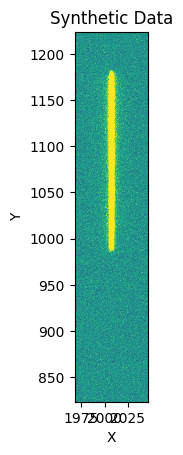

In [6]:
fig, ax = plt.subplots()
ax.pcolormesh(pC, pR, data, vmin=-100, vmax=100)
ax.set(xlabel='X', ylabel='Y', title='Synthetic Data', aspect='equal');

Above we have our fake data. If we were in commissioning, we might take real data here and complete the same steps.

We need to estimate the properties of the PRF. We're going to make an assumption that the spectrum is largely straight and largely verticle. If those aren't true in your data you should think about a different analysis process.

First, let's calculate where the ends of the spectrum are.

In [7]:
aper = (data > 100)
for count in range(3):
    aper |= (np.asarray(np.gradient(aper.astype(float))) != 0).any(axis=0)

In [8]:
pix = pR[:, 0]
spectrum = (data * aper).sum(axis=1)
grad = np.gradient(spectrum, pix)
l = np.argmax(grad)
a, b, c = np.polyfit(pix[l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
sigma = np.sqrt(-1/(2*a))
left_edge = b * sigma**2

l = np.argmin(grad)
a, b, c = np.polyfit(pix[l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
sigma = np.sqrt(-1/(2*a))
right_edge = b * sigma**2

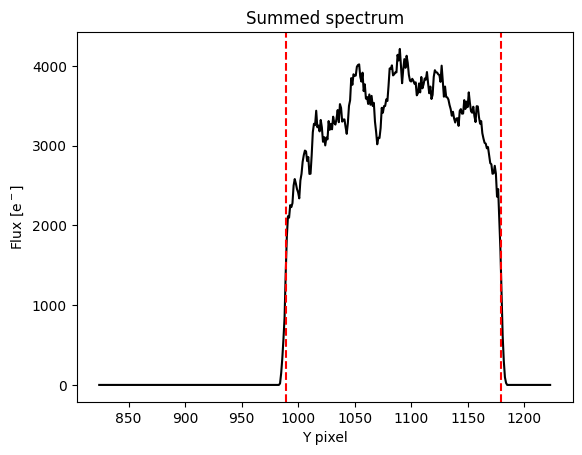

In [9]:
fig, ax = plt.subplots()
ax.plot(pix, spectrum, c='k')
ax.axvline(left_edge, c='r', ls='--')
ax.axvline(right_edge, c='r', ls='--')
ax.set(xlabel='Y pixel', ylabel='Flux [e$^-$]', title='Summed spectrum');

Now we know where the ends of the spectrum are we can calculate the Gaussian profile through each pixel of the trace.

In [10]:
cent, sigma, amp = np.zeros((3, data.shape[0])) * np.nan
mask = aper.astype(float).copy()
mask[~aper] = np.nan
lng = lamatrix.lnGaussian()
ng = lamatrix.Gaussian()
for idx in zip(np.arange(data.shape[0])):
    if pix[idx] < (left_edge + 3):
        continue
    if pix[idx] > (right_edge - 3):
        continue
    if (aper[idx].sum() < 3):
        continue
    tr = data[idx] * mask[idx]
    tr_e = data[idx]**0.5*mask[idx]
    
    l = np.nanargmax(tr)
    lng.priors = lng.gaussian_parameters_to_coefficients([(np.nanmax(tr), np.nanmax(tr)*0.3), (pC[idx][np.nanargmax(tr)], 1), (2, 0.5)])
    lng.fit(x=pC[idx][l-2:l+3], data=np.log(tr[l-2:l+3]), errors=tr_e[l-2:l+3]/tr[l-2:l+3])
    cent[idx] = lng.mu.mean
    sigma[idx] = lng.sigma.mean
    ng.mu = lng.mu.mean
    ng.sigma = lng.sigma.mean
    ng.fit(x=pix[l-2:l+3], data=tr[l-2:l+3])
    amp[idx] = lng.posteriors[0][0]
    
cent -= np.nanmean(cent)

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_64199/548182607.py:14: RuntimeWarning: invalid value encountered in sqrt
  tr_e = data[idx]**0.5*mask[idx]


[Text(0, 0.5, 'Trace Amplitude'), Text(0.5, 0, 'Y Pixel')]

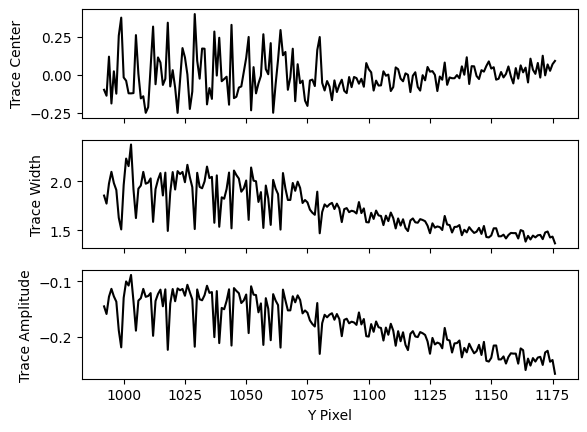

In [11]:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(pix, cent, c='k')
ax[0].set(ylabel='Trace Center')
ax[1].plot(pix, sigma, c='k')
ax[1].set(ylabel='Trace Width')
ax[2].plot(pix, amp, c='k')
ax[2].set(ylabel='Trace Amplitude', xlabel='Y Pixel')

This looks good, we now need to turn this into a PRF model. To do that we'll fit a simple polynomial model to these trends. 

In [12]:
pcent = lamatrix.Polynomial('y', 3) + lamatrix.Constant()
psigma = lamatrix.Polynomial('y', 2) + lamatrix.Constant()
pamp = lamatrix.Polynomial('y', 2) + lamatrix.Constant()

In [13]:
pcent.fit(y=pix + 0.5, data=cent, mask=np.isfinite(cent))
psigma.fit(y=pix + 0.5, data=sigma, mask=np.isfinite(cent))
pamp.fit(y=pix + 0.5, data=amp, mask=np.isfinite(cent))

In [58]:
dp = 4
pix2 = np.arange(np.floor(left_edge) - 10, np.ceil(right_edge) + 10, dp)
cent2 = pcent.evaluate(y=pix2)
sigma2 = psigma.evaluate(y=pix2)
amp2 = pamp.evaluate(y=pix2)

[Text(0, 0.5, 'Trace Amplitude'), Text(0.5, 0, 'Y Pixel')]

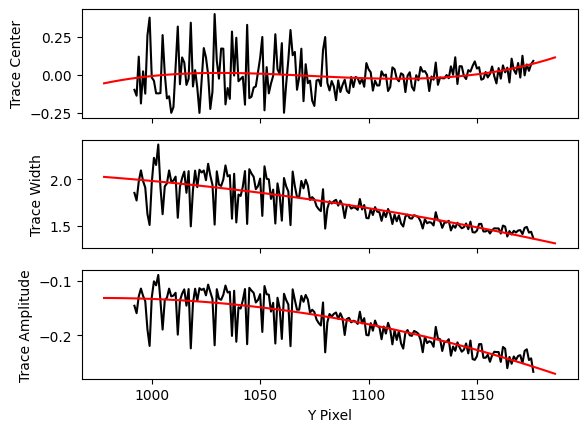

In [59]:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(pix, cent, c='k')
ax[0].plot(pix2, cent2, c='r')
ax[0].set(ylabel='Trace Center')
ax[1].plot(pix, sigma, c='k')
ax[1].plot(pix2, sigma2, c='r')
ax[1].set(ylabel='Trace Width')
ax[2].plot(pix, amp, c='k')
ax[2].plot(pix2, amp2, c='r')
ax[2].set(ylabel='Trace Amplitude', xlabel='Y Pixel')

These models are simple and don't capture all the detail, this is purposeful, in flight we don't know what sort of PRF we are going to get but other factors such as motion are likely to make this fairly smooth.

This is also under the assumption that the trace, or a slide through it, is Gaussian. This isn't a super rigorous assumption but this is the best thing to get us quickly to a PRF model with very little data. 

Now we are going to make a prf model from this. To do this we will evaluate the model, and save it as a FITS file to load into `pandorapsf`

In [60]:
R, C = np.mgrid[-20:20:128j, -20:20:128j]

In [61]:
g2d = lamatrix.Gaussian2D('C', 'R', posteriors=[(1, 1e-10)])
prfs = np.zeros((len(cent2), *R.shape))
for idx in range(cent2.shape[0]):
    g2d.mu_x = cent2[idx]
    g2d.mu_y = 0
    g2d.sigma_x = sigma2[idx]
    g2d.sigma_y = sigma2[idx]
    prfs[idx] = g2d.evaluate(C=C, R=R) * dp

Above I've made a grid of models. I've evaluated the grid at every 0.5 pixels.

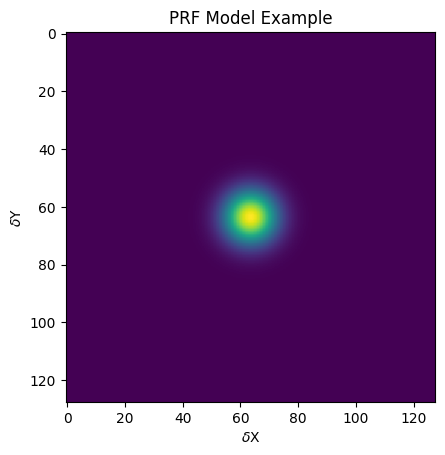

In [62]:
fig, ax = plt.subplots()
ax.imshow(prfs[0])
ax.set(xlabel='$\delta$X', ylabel='$\delta$Y', title='PRF Model Example');

In [63]:
from astropy.io import fits
from astropy.time import Time

In [64]:
hdu0 = fits.PrimaryHDU()
hdu0.header['CREATOR'] = ("Pandora DPC Software", "Software that created this file")
hdu0.header['AUTHOR'] = ("Christina Hedges", "Person or group that created this file")
hdu0.header['VERSION'] = ("Synthetic_V1", "")
hdu0.header['DATASRC'] = ("SIMULATION", "")
hdu0.header['DATE'] = Time.now().isot
hdu0.header["TELESCOP"] = ("NASA Pandora", "telescope")
hdu0.header["CAMERAID"] = ("H2rgCam", "ID of camera used in acquisition")
hdu0.header["INSTRMNT"] = ("NIRDA", "instrument")
hdu0.header['IMSIZE0'] = (pR.shape[0], "Size of the full detector image in ROW")
hdu0.header['IMCRNR0'] = (pR[0, 0], "Corner of the image in ROW.")
hdu0.header['IMSIZE1'] = (pC.shape[1], "Size of the full detector image in COLUMN")
hdu0.header['IMCRNR1'] = (pC[0, 0], "Corner of the image in COLUMN.")
hdu0.header['NORM'] = (dp, "Normalization for each element so that trace sums to 1.")
hdu0.header['PIXSIZE'] = (nirda.pixel_size.value, 'PSF pixel size in micron / pix')
hdu0.header['SUBPIXSZ'] = (np.diff(R, axis=0).mean() * nirda.pixel_size.value, 'PSF sub pixel size in micron / pix')

hdu1 = fits.CompImageHDU(prfs, name='PSF')
hdu2 = fits.ImageHDU(np.zeros_like(pix2), name='X')
hdu2.header['CENTER'] = (40, "Offset to apply to grid points so they are centered in image.")
hdu2.header['UNIT'] = 'pix'
hdu3 = fits.ImageHDU(pix2 - np.mean([right_edge, left_edge]), name='Y')
hdu3.header['CENTER'] = (np.mean([right_edge, left_edge]), "Offset to apply to grid points so they are centered in image.")
hdu3.header['UNIT'] = 'pix'
hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3])
hdulist.writeto("pandora_nir_prf.fits", overwrite=True)

In [65]:
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  PSF           1 CompImageHDU      9   (128, 128, 53)   float64   
  2  X             1 ImageHDU         9   (53,)   float64   
  3  Y             1 ImageHDU         9   (53,)   float64   


In [66]:
!du -sh pandora_nir_prf.fits

2.5M	pandora_nir_prf.fits


Now it's packaged we can load it in as a PRF

In [20]:
prf = pp.PRF.from_file("nirda", "pandora_nir_prf.fits", extrapolate=True)

And build a new scene

In [21]:
pts = pp.PixelTraceScene(np.asarray([[260, 40]]), psf=prf)

This scene can be used to model in the pixel space. Here are some example images if we just dot the model with a column of ones

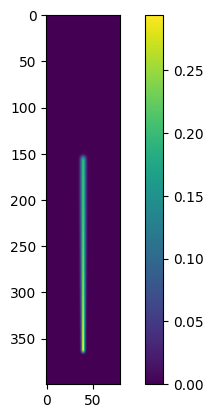

In [104]:
vector = np.ones(pts.npix)
im = pts.model(vector)[0]
plt.imshow(im)
plt.colorbar()

If we sum this up we see a trace which goes between 0 and 1. 

[Text(0.5, 0, 'Pixel Position'), Text(0, 0.5, 'PRF $\\cdot$ 1')]

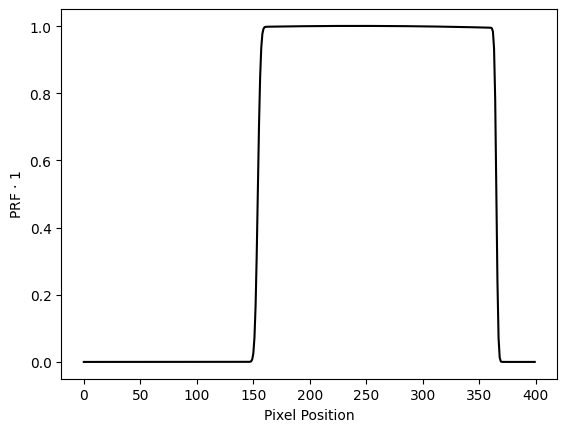

In [105]:
fig, ax = plt.subplots()
ax.plot(im.sum(axis=1), c='k')
ax.set(xlabel='Pixel Position', ylabel='PRF $\cdot$ 1')

If we want to create an aperture out of this we can do so fairly easily (more on this later)

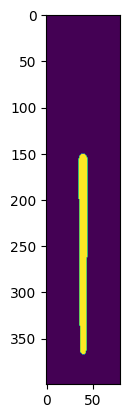

In [107]:
plt.imshow(im > 0.01)

We can move this around fairly easily

Modeling Pixel Positions: 100%|███████████████████| 1/1 [00:00<00:00,  9.46it/s]


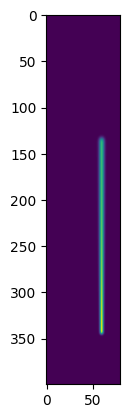

In [117]:
im = pts.model(vector, delta_pos=np.asarray([-20, 20]))[0]
plt.imshow(im)

We can apply some fluxes to see what the PRF will look like. Below we use our best fit amplitudes so it is comparable. I've purposefully evaluated the PRF model past the edges of the spectrum so we can capture it later in our data analysis.

Now we have our PRF model. Remember this doesn't have the correct trace parameters for pixel to wavelength to sensitivity, so we'll need to update those too for us to complete the calibration. 

This PRF model isn't capturing all of the detail in the trace shape, because we're just assuming a Gaussian.

If you complete this activity in commissioning, you should consider applying this to many different datasets, including on stars of different temperatures, so that you can build a model that works well in aggregate. 